# Parameter guide for fingerprinting
The user uploads their data and sets the target attribute.

Our process gives insights of:
- feature importance for the specified target
- robustness of a fingerprint per se (extraction rate)
- utility loss by change in mean and variance (todo: add more parameters)
- utility loss by loss in performance on ML classifiers 
- robustness against classical attacks 
for different gamma values 

In [1]:
import os
os.chdir("C:\\Users\\tsarcevic\\PycharmProjects\\fingerprinting-toolbox")

In [2]:
import pickle

## 0. Upload the data 

In [3]:
data_path = "C:/Users/tsarcevic/PycharmProjects/fingerprinting-toolbox/datasets/adult_full.csv"
target = ['income']

In [4]:
from parameter_guidelines.guidelines import *

In [5]:
# todo: get_full_insights <- this fingerprints the 100 datasets and compresses them later together with metadata

In [6]:
#get_insights(data=data_path, target=target, primary_key_attribute=primary_key)

## 1. Robustness

In [5]:
data = pd.read_csv('datasets/adult.csv', na_values='?')
# # to focus on real stuff, let's ignore missing values
data = data.dropna()

#data = Adult().preprocessed()

In [6]:
xi = 1
fplen = 32
numbuyers = 100
gammae = [1,2,3,4,5,6,10,12,15,18,20,25,30,50,100,200] # 35 40 50 60 70 80

In [7]:
# -------------------------------------------------#
            # ROBUSTNESS EVALUATION #
# ------------------------------------------------ #
def robustness_evaluation(attack, data, attack_string, gammae, attack_granularity=0.05, n_experiments=100, confidence_rate=0.9, 
                          target=None):
    try:
        target = data.get_target_attribute()
    except AttributeError:
        pass
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    if attack_string == 'vertical':
        file_string = 'robustness_{}_universal_c{}_e{}.pickle'.format(attack_string,
                                                                                format(confidence_rate,".2f")[-2:], 
                                                                                n_experiments)
    else:
        file_string = 'robustness_{}_universal_c{}_ag{}_e{}.pickle'.format(attack_string,
                                                                                    format(confidence_rate,".2f")[-2:], 
                                                                                    format(attack_granularity,".2f")[-2:], 
                                                                                    n_experiments)
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #

    for gamma in gammae_new:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # from how much remaining data can the fingerprint still be extracted?
        remaining = robustness(attack, scheme, exclude=[target], 
                                       attack_granularity=attack_granularity,
                                      n_experiments=n_experiments, 
                                      confidence_rate=confidence_rate)
        resutls[gamma] = remaining
    resutls =  dict(sorted(resutls.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(resutls, outfile)

In [45]:
def robustness_statistical(attack, data, attack_string, gammae, attack_granularity=0.05, confidence_rate=0.9):
    file_string = 'robustness_stat_{}_universal_c{}_ag{}.pickle'.format(attack_string, 
                                                                       format(confidence_rate,".2f")[-2:],
                                                                       format(attack_granularity,".2f")[-2:])
    # check if results exist
    # ---------------------- #
    if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
        with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            resutls = pickle.load(infile)
    else:
        resutls = {}
    gammae_new = []
    for gamma in gammae:
        if gamma not in resutls.keys():
            gammae_new.append(gamma)
            print('Updating results with gamma={}'.format(gamma))
    # ---------------------- #
    
    xi = 1
    fplen = 32
    numbuyers = 100
    
    result = dict()
    for gamma in gammae:
        scheme = Universal(gamma=gamma, 
                            xi=xi, 
                            fingerprint_bit_length=fplen, 
                            number_of_recipients=numbuyers)
        # find a strenght for which the attack success drops below 10%
        attack_strength = attack_granularity
        # if i flip 5% of data, what is the probability of attack success
        fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it less than 10%? let's increase the strength to see if this was the boundary
        while(fm < 1-confidence_rate):
            attack_strength += attack_granularity
        # if i flip 5% of data, what is the probability of attack success
            fm = attack.false_miss_estimation(data, attack_strength, scheme) 
        # is it more than 10%? then the previous strength was the robustness
        robustness = attack_strength - attack_granularity
        result[gamma] = round(robustness,2)
    result =  dict(sorted(result.items()))
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(result, outfile)
    return result

In [46]:
attack = FlippingAttack()

In [51]:
robustness_statistical(attack, data, 'flipping', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.02)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.46,
 2: 0.44,
 3: 0.42,
 4: 0.42,
 5: 0.4,
 6: 0.4,
 10: 0.38,
 12: 0.36,
 15: 0.34,
 18: 0.34,
 20: 0.32,
 25: 0.3,
 30: 0.28,
 35: 0.28,
 40: 0.24,
 50: 0.24,
 60: 0.2,
 70: 0.2,
 80: 0.14,
 100: 0.14,
 200: 0.04}

### 1.1. Horizontal subset attack

In [10]:
attack = HorizontalSubsetAttack()

In [11]:
robustness_evaluation(attack, data, 'horizontal', [1,2,3,6,10,50], confidence_rate=0.70, n_experiments=2, target='income')

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=50
Subset attack runtime on 2261 out of 45222 entries: 0.0030050277709960938 sec.
Start detection algorithm...
	gamma: 1
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11001101010111101100101001011010
Counts:
[[0, 83],
 [0, 77],
 [76, 0],
 [65, 0],
 [0, 69],
 [0, 52],
 [79, 0],
 [0, 57],
 [71, 0],
 [0, 70],
 [72, 0],
 [0, 64],
 [0, 86],
 [0, 68],
 [0, 68],
 [66, 0],
 [0, 74],
 [0, 80],
 [68, 0],
 [57, 0],
 [0, 86],
 [70, 0],
 [0, 64],
 [67, 0],
 [62, 0],
 [0, 73],
 [67, 0],
 [0, 69],
 [0, 68],
 [75, 0],
 [0, 71],
 [87, 0]]
Recipient

Potential fingerprint detected: 11100010011001101001011101001110
Counts:
[[0, 4],
 [0, 12],
 [0, 5],
 [7, 0],
 [5, 0],
 [3, 0],
 [0, 4],
 [6, 0],
 [5, 0],
 [0, 3],
 [0, 6],
 [6, 0],
 [10, 1],
 [0, 7],
 [0, 6],
 [8, 0],
 [0, 8],
 [4, 0],
 [9, 0],
 [0, 5],
 [6, 0],
 [0, 13],
 [0, 5],
 [0, 9],
 [8, 1],
 [0, 5],
 [7, 0],
 [10, 0],
 [0, 9],
 [0, 6],
 [0, 9],
 [5, 0]]
Recipient 1 is suspected.
Runtime: 0 sec.
Subset attack runtime on 2261 out of 45222 entries: 0.003000497817993164 sec.
Start detection algorithm...
	gamma: 50
	fingerprint length: 32
	detecting a fingerprint from columns: Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')
Potential fingerprint detected: 11021221010112121100121020211010
Counts:
[[0, 1],
 [1, 2],
 [2, 0],
 [1, 1],
 [0, 2],
 [0, 0],
 [0, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 

<IPython.core.display.Javascript object>


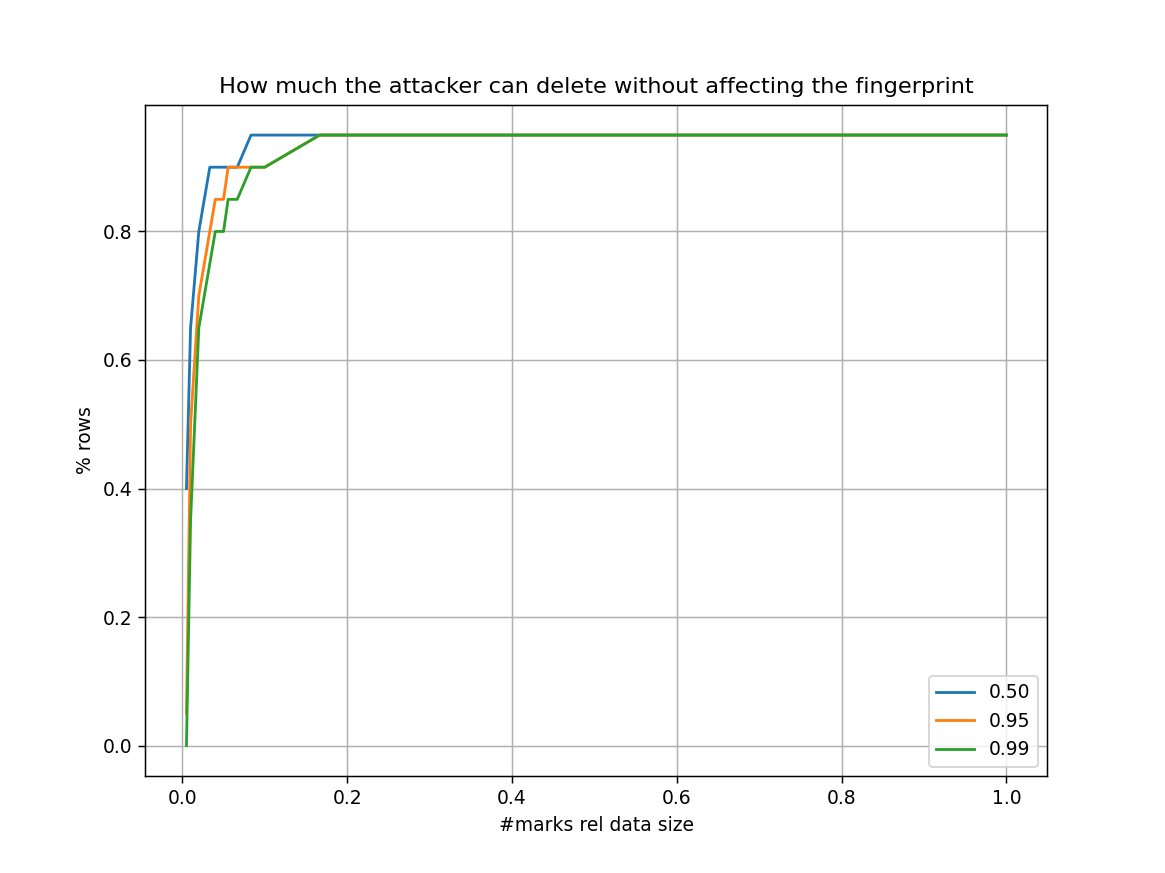

In [12]:
%matplotlib notebook
confidence_rates = [0.50, 0.95, 0.99]
attack_granularity = 0.05
n_experiments = 100
for confidence_rate in confidence_rates:
    file_string = 'inverse_robustness_horizontal_universal_c{}_ag{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       format(attack_granularity,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.2. Vertical subset attack

In [ ]:
attack = VerticalSubsetAttack()

In [ ]:
robustness_evaluation(attack, data, 'vertical', gammae=[1, 2, 50], confidence_rate=0.95, target='income', n_experiments=2) 

<IPython.core.display.Javascript object>


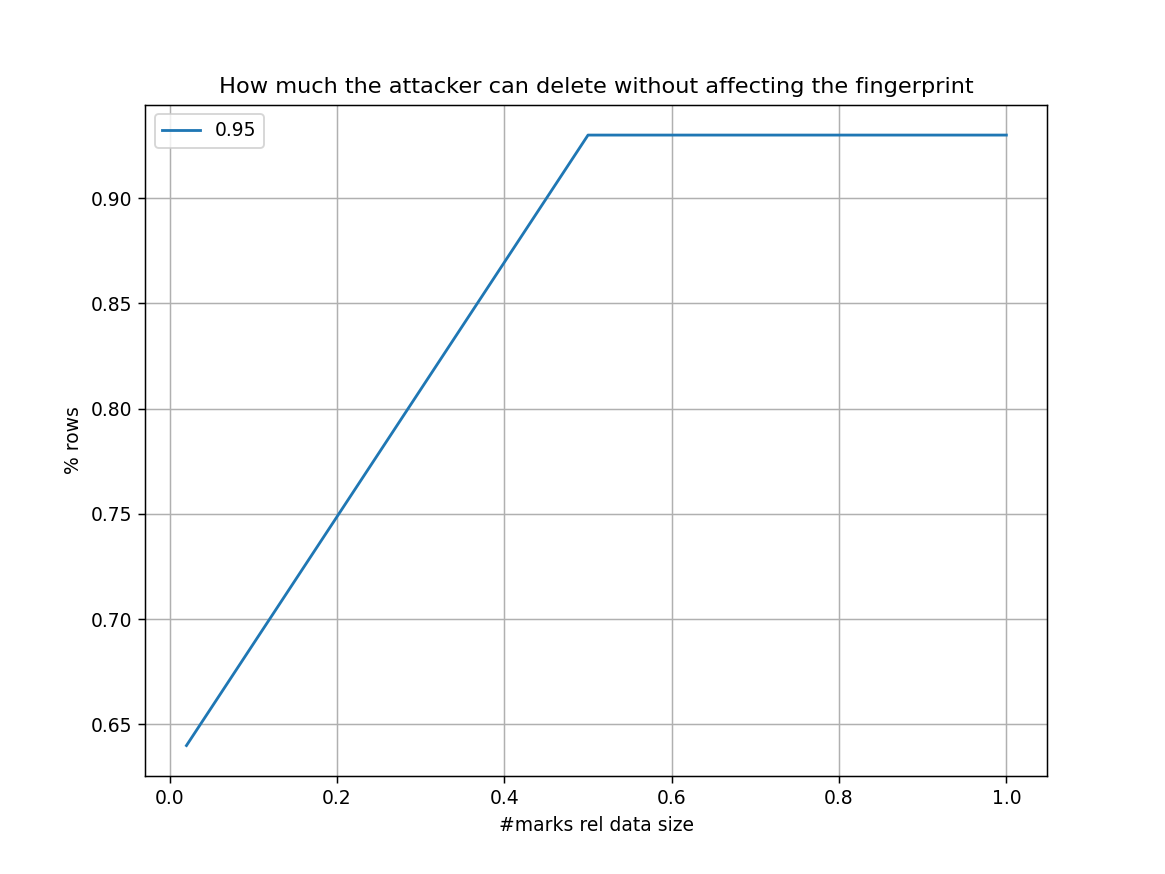

In [12]:
%matplotlib notebook
confidence_rates = [0.95]
n_experiments = 3
for confidence_rate in confidence_rates:
    file_string = 'robustness_vertical_universal_c{}_e{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                                       n_experiments)
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

### 1.3. Flipping attack

In [52]:
attack = FlippingAttack()

In [10]:
#robustness_evaluation(attack, data, 'flipping', gammae=[1], confidence_rate=0.95, target='income', n_experiments=1, 
#                      attack_granularity=0.1)

In [55]:
robustness_statistical(attack, data, 'flipping', gammae=[1,2,3,4,5,6,10,12,15,18,20,25,30,35,40,50,60,70,80,100,200],
                      attack_granularity=0.02, confidence_rate=0.95)

Updating results with gamma=1
Updating results with gamma=2
Updating results with gamma=3
Updating results with gamma=4
Updating results with gamma=5
Updating results with gamma=6
Updating results with gamma=10
Updating results with gamma=12
Updating results with gamma=15
Updating results with gamma=18
Updating results with gamma=20
Updating results with gamma=25
Updating results with gamma=30
Updating results with gamma=35
Updating results with gamma=40
Updating results with gamma=50
Updating results with gamma=60
Updating results with gamma=70
Updating results with gamma=80
Updating results with gamma=100
Updating results with gamma=200


{1: 0.46,
 2: 0.44,
 3: 0.42,
 4: 0.4,
 5: 0.4,
 6: 0.4,
 10: 0.36,
 12: 0.34,
 15: 0.34,
 18: 0.32,
 20: 0.32,
 25: 0.3,
 30: 0.26,
 35: 0.26,
 40: 0.24,
 50: 0.22,
 60: 0.18,
 70: 0.18,
 80: 0.14,
 100: 0.14,
 200: 0.02}

<IPython.core.display.Javascript object>


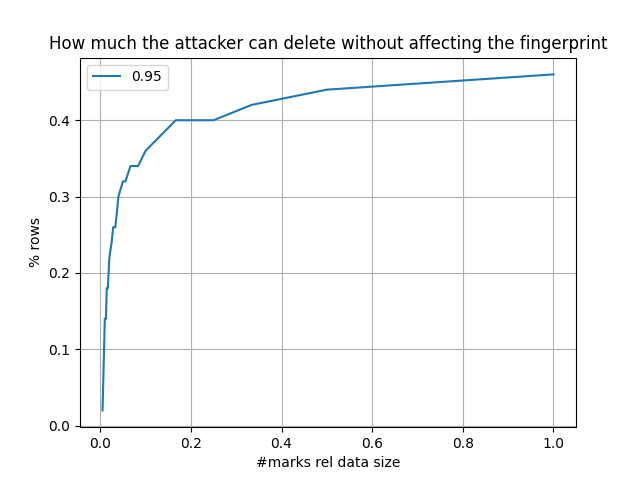

In [57]:
%matplotlib notebook
confidence_rates = [0.95]
attack_granularity= 0.02
for confidence_rate in confidence_rates:
    file_string = 'robustness_stat_flipping_universal_c{}_ag{}.pickle'.format(format(confidence_rate,".2f")[-2:], 
                                                                             format(attack_granularity, ".2f")[-2:])
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        resutls = pickle.load(infile)
    plt.plot([1.0/g for g in resutls.keys()], [robustness for robustness in resutls.values()], 
             label= str(format(confidence_rate,".2f")))
plt.title('How much the attacker can delete without affecting the fingerprint')
plt.xlabel('#marks rel data size') 
plt.ylabel('% rows')
plt.legend()
plt.grid()

In [12]:
resutls

{1: 0.9}

## 2. Attack utility decrease

In [15]:
results = {}
attack_granularity = 0.05
n_folds = 5
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
# check if results exist
# ---------------------- #
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # returns estimated utility drop for each attack strength
    attack_utility_knn = attack_utility_knn(Adult().preprocessed(), target, attack, attack_granularity=attack_granularity, 
                                            n_folds=n_folds)


    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(attack_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')
# ---------------------- #

Results already exist. Not taking any action.


In [71]:
file_string = 'attack_utility_horizontal_universal_knn_{}_ag{}_nf{}.pickle'.format(target, 
                                                                               format(attack_granularity,".2f")[-2:], 
                                                                                   n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    attack_utility_knn = pickle.load(infile)
attack_utility_knn = dict(sorted(attack_utility_knn.items()))

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


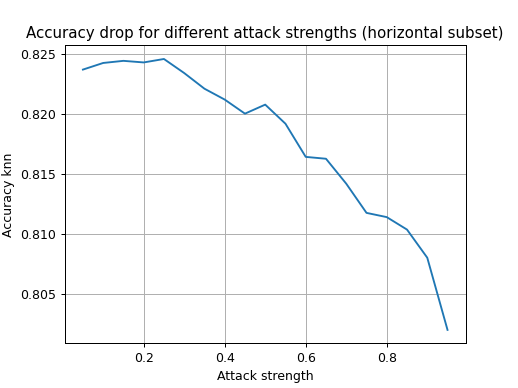

Text(0.5, 1.0, 'Accuracy drop for different attack strengths (horizontal subset)')

In [72]:
%matplotlib
plt.plot(attack_utility_knn.keys(), [np.mean(acc) for acc in attack_utility_knn.values()])
plt.xlabel('Attack strength')
plt.ylabel('Accuracy knn')
plt.title('Accuracy drop for different attack strengths (horizontal subset)')

In [18]:
# original accuracy
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
if not os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    # from how much remaining data can the fingerprint still be extracted?
    original_utility_knn = original_utility_knn(Adult().preprocessed(), target, n_folds=n_folds)

    with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(original_utility_knn, outfile)
else:
    print('Results already exist. Not taking any action.')

Results already exist. Not taking any action.


In [19]:
file_string = 'utility_knn_{}_nf{}.pickle'.format(target, n_folds)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
    original_utility_knn = pickle.load(infile)

In [20]:
#acceptable_utility_drop = 0.01
#utility_preserving_attack_strength = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=acceptable_utility_drop])
# alternative
# attacks that yield at least 1% of accuracy loss
#attacks_1p = max([strength for strength in attack_utility_knn 
#                  if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.01])
# attacks that yield at least 2% of accuracy loss
#attacks_2p = max([strength for strength in attack_utility_knn 
#                                         if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.02])
#
#attacks_3p = max([strength for strength in attack_utility_knn
#                 if np.mean(original_utility_knn)-np.mean(attack_utility_knn[strength])<=0.03])

In [21]:
#max_utility_drop = np.mean(original_utility_knn) - min(np.mean(acc) for acc in attack_utility_knn.values())

In [75]:
# retruns a list [attack_with_1%_loss, attack_with_2%_loss, ... , max_abs_utility_loss]
att_utility_bounds = attack_utility_bounds(original_utility_knn, attack_utility_knn) 

<IPython.core.display.Javascript object>


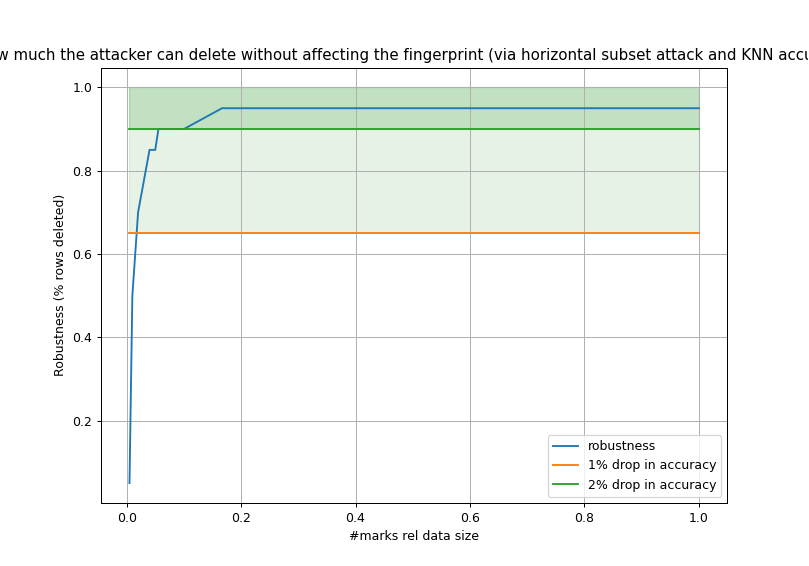

In [76]:
%matplotlib notebook
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)
fig, ax = plt.subplots(figsize=(10, 7))

lines = []
fill = []

lines.append(ax.plot([1.0/g for g in resutls.keys()], [1 - inv_robustness for inv_robustness in resutls.values()], label='robustness'))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[0] for x in resutls], 1.0, color='green', alpha=0.1))
lines.append(ax.plot([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy'))
fill.append(ax.fill_between([1.0/g for g in resutls.keys()], [att_utility_bounds[1] for x in resutls], 1.0, color='green', alpha=0.15))

plt.title('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN accuracy)')
plt.xlabel('#marks rel data size') 
plt.ylabel('Robustness (% rows deleted)')

legend = plt.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]]
graphs[line_legends[1]] = [lines[1][0], fill[0]]
graphs[line_legends[2]] = [lines[2][0], fill[1]]
   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

## 3. Utility after fingerprinting

### 3.1. KNN 

In [86]:
#gammae = [1, 3, 6, 12, 25, 50, 100]
fp_utility_results = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results = pickle.load(infile)
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    fp_utility_knn = fingerprint_utility_knn(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results[gamma] = fp_utility_knn
    
fp_utility_results =  dict(sorted(fp_utility_results.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results, outfile)

Using matplotlib backend: nbAgg


<IPython.core.display.Javascript object>


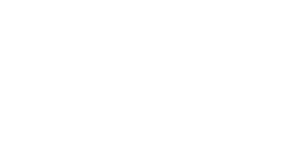

Text(0, 0.5, 'Accuracy knn')

In [87]:
%matplotlib
file_string = 'utility_universal_knn_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[gamma]]) for gamma in fp_utility_results.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')

### 3.2. Decision Tree

In [88]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_DT = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_DT = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_DT.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_DT.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_dt = fingerprint_utility_dt(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_DT[gamma] = fp_utility_dt
    
fp_utility_results_DT =  dict(sorted(fp_utility_results_DT.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_DT, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


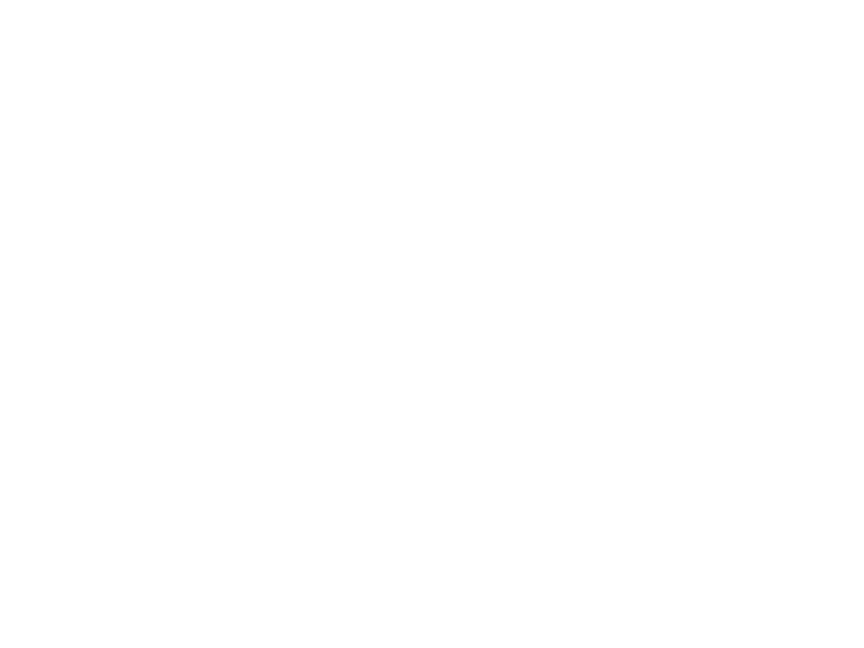

In [89]:
%matplotlib notebook
file_string = 'utility_universal_dt_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_DT = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_DT.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[gamma]]) for gamma in fp_utility_results_DT.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

### 3.3 Gradient Boosting

In [90]:
#gammae = [1, 2, 3, 4, 6, 12, 25, 50, 100]
fp_utility_results_GB = {}
n_folds = 5
n_experiments = 10

file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)

# check if results exist
# ---------------------- #
if os.path.isfile('parameter_guidelines/evaluation/adult/'+file_string):
    with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
            fp_utility_results_GB = pickle.load(infile)
    print('Results already exist for gammae: ' + str(fp_utility_results_GB.keys()))
gammae_new = []
for gamma in gammae:
    if gamma not in fp_utility_results_GB.keys():
        gammae_new.append(gamma)
# ---------------------- #        
# update results
for gamma in gammae_new:
    print('Updating results for gamma='+str(gamma))
    fp_utility_gb = fingerprint_utility_gb(Adult(), target, gamma, n_folds=n_folds, n_experiments=n_experiments) 
    # [cv_acc_1, cv_acc_2, ..., cv_acc_n_exp]
    fp_utility_results_GB[gamma] = fp_utility_gb
    
fp_utility_results_GB =  dict(sorted(fp_utility_results_GB.items()))
with open('parameter_guidelines/evaluation/adult/'+file_string, 'wb') as outfile:
        pickle.dump(fp_utility_results_GB, outfile)

Updating results for gamma=1
Updating results for gamma=2
Updating results for gamma=3
Updating results for gamma=4
Updating results for gamma=5
Updating results for gamma=6
Updating results for gamma=10
Updating results for gamma=12
Updating results for gamma=15
Updating results for gamma=18
Updating results for gamma=20
Updating results for gamma=25
Updating results for gamma=30
Updating results for gamma=50
Updating results for gamma=100
Updating results for gamma=200


<IPython.core.display.Javascript object>


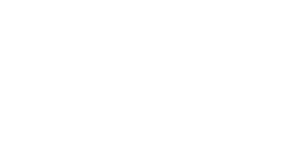

In [91]:
%matplotlib notebook
file_string = 'utility_universal_gb_{}_nf{}_e{}.pickle'.format(target, n_folds, n_experiments)
with open('parameter_guidelines/evaluation/adult/'+file_string, 'rb') as infile:
        fp_utility_results_GB = pickle.load(infile)
        
x_axis = [1.0/g for g in fp_utility_results_GB.keys()]
y_axis = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[gamma]]) for gamma in fp_utility_results_GB.keys()]
plt.plot(x_axis, y_axis, label='utility after fingerprint')
plt.title('Utility of fingerprinted data')
plt.xlabel('#marks rel data size')
plt.ylabel('Accuracy knn')
plt.show()

## COMBINED RESULTS

In [36]:
with open('parameter_guidelines/evaluation/adult/inverse_robustness_horizontal_universal_c95_ag05_e100.pickle', 'rb') as infile:
    resutls = pickle.load(infile)

In [37]:
# interceptions
x_intercept_0 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[0]]))
x_intercept_1 = 1.0/(max([x for x in resutls if 1-resutls[x]>=att_utility_bounds[1]]))

<IPython.core.display.Javascript object>


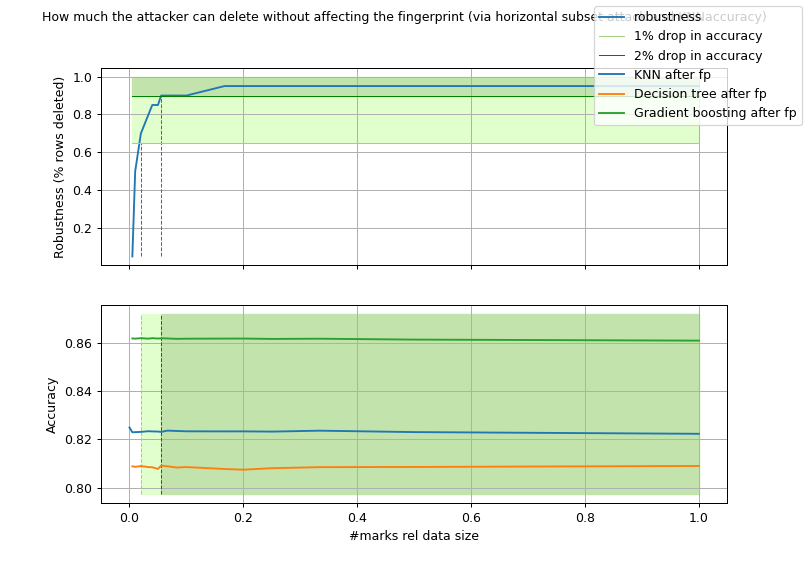

In [98]:
# incorporate in the full analysis
%matplotlib notebook
fig, ax = plt.subplots(2, sharex=True, figsize=(10, 7)) # sharey=True

lines = []
fill = []
helpers = []

x_axis = [1.0/g for g in gammae]

# ---------------------------- #
# robustness
# ---------------------------- #
y_robustness = [1 - inv_robustness for inv_robustness in resutls.values()]
lines.append(ax[0].plot(x_axis, y_robustness, label='robustness'))

# --------------------------- #
# utility (start)
# --------------------------- #
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]])
             for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
y_utility_DT = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_DT[g]])
                for g in fp_utility_results_DT.keys()]
y_utility_GB = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results_GB[g]])
                for g in fp_utility_results_GB.keys()]
y_utility_all = y_utility + y_utility_DT + y_utility_GB

# --------------------------- #
# attack utility
# --------------------------- #
lw = 0.8
bound_patch = 0.01

lines.append(ax[0].plot(x_axis, [att_utility_bounds[0] for x in resutls], label='1% drop in accuracy', linewidth=lw, 
                        color='#a2d180'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[0] for x in resutls], 1.0, color='#e1ffcc'))
helpers.append(ax[0].vlines(x=x_intercept_0, ymin=min(y_robustness), ymax=att_utility_bounds[0], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_0, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='#a2d180'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_0], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#e1ffcc'))

lines.append(ax[0].plot(x_axis, [att_utility_bounds[1] for x in resutls], label='2% drop in accuracy', linewidth=lw, 
                        color='green'))
fill.append(ax[0].fill_between(x_axis, [att_utility_bounds[1] for x in resutls], 1.0, color='#c3e3ac'))
helpers.append(ax[0].vlines(x=x_intercept_1, ymin=min(y_robustness), ymax=att_utility_bounds[1], linewidth=lw, 
                            linestyles='dashed'))
helpers.append(ax[1].vlines(x=x_intercept_1, ymin=min(y_utility_all)-bound_patch, ymax=max(y_utility_all)+bound_patch, 
                            linewidth=lw, linestyles='dashed', color='green'))
fill.append(ax[1].fill_between([x for x in x_axis if x>=x_intercept_1], min(y_utility_all)-bound_patch,
                               max(y_utility_all)+bound_patch, color='#c3e3ac'))

# todo: mark on the first subplot (ax[0]) when the utility gets way too low; eg. -1%, -2% etc

# ---------------------------- #
# utility
# ---------------------------- #
# KNN
y_utility = [np.mean([np.mean(cv_res) for cv_res in fp_utility_results[g]]) 
                                    for g in fp_utility_results.keys()] + [np.mean(original_utility_knn)]
lines.append(ax[1].plot(x_axis+[0.0], y_utility, label='KNN after fp'))
# Decision Tree
lines.append(ax[1].plot(x_axis, y_utility_DT, label='Decision tree after fp'))
# Gradient Boosting
lines.append(ax[1].plot(x_axis, y_utility_GB, label='Gradient boosting after fp'))
ax[1].set_ylabel('Accuracy')
# ---------------------------- #

fig.suptitle('How much the attacker can delete without affecting the fingerprint (via horizontal subset attack and KNN' + 
             'accuracy)', size=10)
plt.xlabel('#marks rel data size') 
ax[0].set_ylabel('Robustness (% rows deleted)')

plt.rcParams['axes.grid'] = True

legend = fig.legend()
line_legends = legend.get_lines()
for line in line_legends:
    line.set_picker(True)
    line.set_pickradius(10)
graphs = {}
graphs[line_legends[0]] = [lines[0][0]] # -> robustness
graphs[line_legends[1]] = [lines[1][0], fill[0], helpers[0], fill[1], helpers[1]] # -> attack utility 
graphs[line_legends[2]] = [lines[2][0], fill[2], helpers[2], fill[3], helpers[3]]
graphs[line_legends[3]] = [lines[3][0]] # -> utility
graphs[line_legends[4]] = [lines[4][0]]
graphs[line_legends[5]] = [lines[5][0]]

   
def on_pick(event):
    legend = event.artist
    isVisible = legend.get_visible()
    for element in graphs[legend]:
        element.set_visible(not isVisible)
    legend.set_visible(not isVisible)
    fig.canvas.draw()
    
plt.connect('pick_event', on_pick)
plt.show()

Robustness plot (above):
- in the dark green area, the utility of the attacker's data is expected to drop at least 2% for the observed attacks, in addition to the increased robustness for that area. This helps determining the lower boundary on what is considered a robust scheme. Therefore, on the one hand, while choosing the number of marks (x axis), the user can say "if the attacker needs to modify at least 50% of data (i.e. robustness=50%), the scheme is robust", or on the other hand "if the attacker loses more than 2% of accuracy by modifying the data, the scheme is considered robust", or a combination of both. 
- the light green area represents where the utility is expected to drop at least 1% due to the attack strength

Utility plot (below):
- the dark and light green areas are transposed to help find the lower boundary of number of marks that the user wants to chose
- users wants to choose the #marks (x axis) with the highest accuracy
- the idea for the alternative plot regarding utility might be to plot relative delta accuracy (real_acc-original_acc)/original_acc -> for each classifier and cumulative